# У вас есть данные АБ-теста алгоритма ранжирования в новостях

Данные лежат в [файле](https://github.com/pileyan/HSE_Statistics_1/blob/main/lect%2010%20CUPED/news%20test.csv)

Каждая строка - статистика о том, какой набор действий совершил за этот день пользователь (строка = пользователь+день)

**d** - День

**exp_group** -  id экспериментальной группы

**bot_flg** - 1 - мы считаем пользователя ботом, 0 - считаем живым пользователем

**user_info_yandex_uid** - уникальный id пользователя

**total_clicks_** - сколько кликов по поисковой выдаче сделал пользователь за день

**time_to_first_click_** - Если пользователь хоть раз кликнул по поисковой выдаче по запросу, то для каждого запроса высчитывается "какое время прошло от показа выдачи до 1 клика". Если человек сделал несколько запросов, по каждому из них считается время до первого клика, а затем суммируется 

**first_click_pos_** - Если пользователь хоть раз кликнул по поисковой выдаче по запросу, то для каждого запроса высчитывается "В какую именно позицию пользователь кликнул первой". Если человек сделал несколько запросов, по каждому из тех, в которых был клик, считается позиция первого клика, а затем суммируется 

**sum_pos** - Выдача в новостях устроена "блоками". Позиции в каждом из блоков можно пронумеровать (каждый новый блок начинается с 1). Если человек совершил клик в некоторую позицию, считается ее номер внутри блока и суммируется с позициями других его кликов

**end2end_sum_pos** - По выдаче можно ввести "сквозную нумерацию", то есть не "внутри каждого блока начинаем с 1", а просто нумеруем от начала и до конца. Далее берем все клики пользователя, считаем "сквозную позицию кликнутых документов" и суммируем 

**queries** - количество запросов за день 

**empty_results** - количество запросов , вернувших пустую выдачу

# Задание 1

Проверьте с помощью подходящего теста (и поясните, почему этот тест хорошо подходит для этой метрики) статистическую значимость отличия в следующем списке метрик:


1) Среднее количество кликов на пользователя за весь период эксперимента

2) Средняя позиция клика (сумма позиций/кол-во кликов)

3) Средняя сквозная позиция клика (сумма сквозных позиций/кол-во кликов)

4) Доля пустых результатов выдачи


Также очень рекомендуется провести EDA и посмотреть, нет ли в данных чего-то интересного) Хороший EDA поможет вам лучше разобраться, что , как и с чем взаимосвязано.

# Задание 2

Постройте графики метрик из пунктов 1-4 по дням, чтобы посмотреть, виден ли эффект, который вы измерили с помощью теста, невооруженным глазом. А также - является ли он стабильным во времени.

# Задание 3

Проанализируйте результаты пунктов 1-4 , убрав из групп ботов. Изменились ли выводы?


In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('news test.csv')

In [13]:
df = df.drop(['is_biterika', 'is_yandex', 'is_sber', 'is_rntv',
       'is_vtb', 'is_telegram_bot', 'is_yandex_bot', 'is_medialogia',
       'is_selectel', 'is_interfax', 'is_RT'], axis = 1)

df= df.drop(['user_info_user_agent', 'kommersant',
       'kommersant_shows', 'rbc', 'rbc_shows', 'ria', 'ria_shows', 'lenta',
       'lenta_shows', 'tass', 'tass_shows', 'iz', 'iz_shows', 'interfax',
       'interfax_shows'], axis = 1)

df['dt'] = pd.to_datetime(df.d, format = '%d/%m/%y')

In [7]:
df

,d,exp_group,bot_flg,user_info_yandex_uid,total_clicks_,time_to_first_click_,first_click_pos_,sum_pos,end2end_sum_pos,queries,empty_results,dt
0,26/04/23,control,0,1865850381682515486,0,0,0,0,0,1,1,2023-04-26
1,28/04/23,хронология,0,8022259061682679060,0,0,0,0,0,1,0,2023-04-28
2,28/04/23,control,1,8516704241675260594,0,0,0,0,0,278,203,2023-04-28
3,01/05/23,control,0,6430450711682974597,0,0,0,0,0,1,0,2023-05-01
4,27/04/23,хронология,0,5047628321682545957,0,0,0,0,0,1,0,2023-04-27
...,...,...,...,...,...,...,...,...,...,...,...,...
251688,28/04/23,control,0,4935607761674553118,0,0,0,0,0,2,0,2023-04-28
251689,26/04/23,хронология,0,4832233251682471511,0,0,0,0,0,1,0,2023-04-26
251690,29/04/23,control,0,5520044421682742770,0,0,0,0,0,1,0,2023-04-29
251691,29/04/23,control,0,9995464511682731826,0,0,0,0,0,1,0,2023-04-29


In [6]:

q = '''
select exp_group, 
    count_if(clicks=0) as zero_clicks,
    sum(1) as total,
    count_if(clicks=0)/sum(1) as zero_clicks_ratio
from (
SELECT user_info_yandex_uid, exp_group, sum(total_clicks_) as clicks
FROM df
WHERE bot_flg = 0
GROUP BY user_info_yandex_uid, exp_group
)
group by exp_group
'''

duckdb.query(q).to_df()

,exp_group,zero_clicks,total,zero_clicks_ratio
0,control,109822.0,113382.0,0.968602
1,хронология,109855.0,113453.0,0.968286


In [110]:
df

,d,exp_group,bot_flg,user_info_yandex_uid,total_clicks_,time_to_first_click_,first_click_pos_,sum_pos,end2end_sum_pos,queries,empty_results,dt
0,26/04/23,control,0,1865850381682515486,0,0,0,0,0,1,1,2023-04-26
1,28/04/23,хронология,0,8022259061682679060,0,0,0,0,0,1,0,2023-04-28
2,28/04/23,control,1,8516704241675260594,0,0,0,0,0,278,203,2023-04-28
3,01/05/23,control,0,6430450711682974597,0,0,0,0,0,1,0,2023-05-01
4,27/04/23,хронология,0,5047628321682545957,0,0,0,0,0,1,0,2023-04-27
...,...,...,...,...,...,...,...,...,...,...,...,...
251688,28/04/23,control,0,4935607761674553118,0,0,0,0,0,2,0,2023-04-28
251689,26/04/23,хронология,0,4832233251682471511,0,0,0,0,0,1,0,2023-04-26
251690,29/04/23,control,0,5520044421682742770,0,0,0,0,0,1,0,2023-04-29
251691,29/04/23,control,0,9995464511682731826,0,0,0,0,0,1,0,2023-04-29


In [113]:
q = '''
    select user_info_yandex_uid,
        exp_group,
        sum(time_to_first_click_) as time_to_first_click,
        sum(total_clicks_) as click_total,
        count(distinct dt) as uniq_dt
    from 
        (SELECT user_info_yandex_uid, 
            total_clicks_,
            exp_group, 
            time_to_first_click_,
            dt
            
        FROM df
        WHERE bot_flg = 0
            and total_clicks_ > 0
        )
    GROUP BY user_info_yandex_uid, exp_group
'''

time_df = duckdb.query(q).to_df()

In [121]:
ttest_ind(time_df[time_df.exp_group == 'хронология'].time_to_first_click,
          time_df[time_df.exp_group != 'хронология'].time_to_first_click,
          equal_var = False)

Ttest_indResult(statistic=0.8559834149027711, pvalue=0.39203564185084494)

In [16]:
df.groupby(['exp_group'])['user_info_yandex_uid'].nunique()

exp_group
control       118874
хронология    119117
Name: user_info_yandex_uid, dtype: int64

In [ ]:
df.exp_group.value_counts()

In [19]:
clicked_df.groupby(['exp_group'])['user_info_yandex_uid'].nunique()

exp_group
control       3560
хронология    3598
Name: user_info_yandex_uid, dtype: int64

In [28]:
import seaborn as sns
import numpy as np

<Axes: >

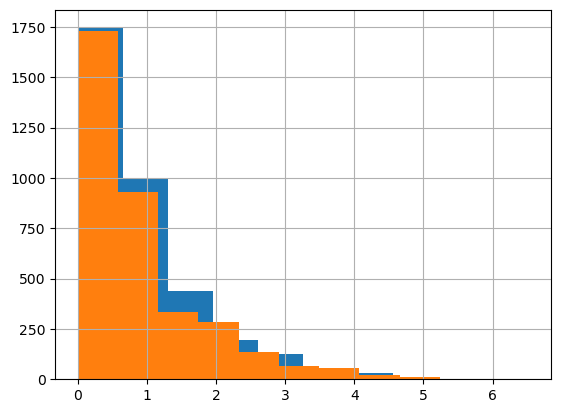

In [32]:
np.log(clicked_df[clicked_df.exp_group == 'хронология'].clicks).hist()
np.log(clicked_df[clicked_df.exp_group != 'хронология'].clicks).hist()

In [35]:
clicked_df[clicked_df.exp_group == 'хронология'].clicks.median(), clicked_df[clicked_df.exp_group != 'хронология'].clicks.median()

(2.0, 2.0)

In [41]:
np.quantile(clicked_df[clicked_df.exp_group == 'хронология'].clicks, 0.95), np.quantile(clicked_df[clicked_df.exp_group != 'хронология'].clicks, 0.95)

(16.0, 16.0)

In [42]:
group1 = clicked_df[clicked_df.exp_group == 'хронология'].clicks

In [46]:
group1.to_numpy()

array([ 1.,  3., 23., ...,  2.,  1.,  1.])

In [52]:
bootstrapped1 = np.random.choice(group1.to_numpy(), size = (3598, 1000), replace = True)

(array([ 11.,  56., 183., 273., 234., 144.,  76.,  16.,   4.,   3.]),
 array([4.03085047, 4.22520845, 4.41956643, 4.6139244 , 4.80828238,
        5.00264036, 5.19699833, 5.39135631, 5.58571429, 5.78007226,
        5.97443024]),
 <BarContainer object of 10 artists>)

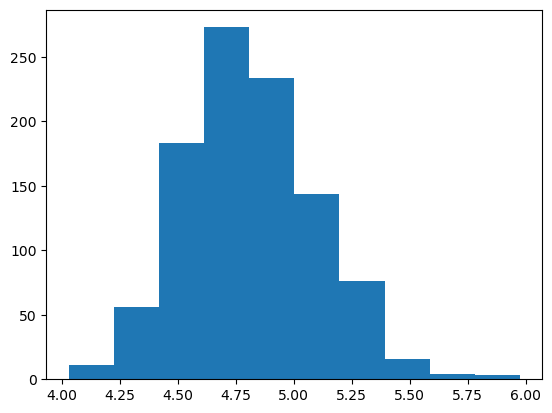

In [56]:
plt.hist(bootstrapped1.mean(axis = 0))

In [58]:
a = clicked_df[clicked_df.exp_group == 'хронология'].clicks.to_numpy()
b = clicked_df[clicked_df.exp_group != 'хронология'].clicks.to_numpy()

In [59]:
from scipy.stats import ttest_ind

In [61]:
ttest_ind(a,b,equal_var = False)

Ttest_indResult(statistic=0.24897684145455282, pvalue=0.8033862364991592)

In [64]:
bootstrapped1 = np.random.choice(a, size = (a.shape[0], 1000), replace = True)
bootstrapped2 = np.random.choice(b, size = (b.shape[0], 1000), replace = True)

In [67]:
bootstrapped1

array([[ 2., 17.,  2., ...,  2., 11.,  1.],
       [ 1.,  6.,  1., ...,  3.,  6.,  1.],
       [ 3.,  1.,  2., ...,  1.,  1., 12.],
       ...,
       [ 1.,  2.,  1., ...,  1.,  1.,  1.],
       [ 2.,  1.,  1., ...,  2.,  8.,  1.],
       [ 2., 10.,  1., ...,  4.,  1.,  1.]])

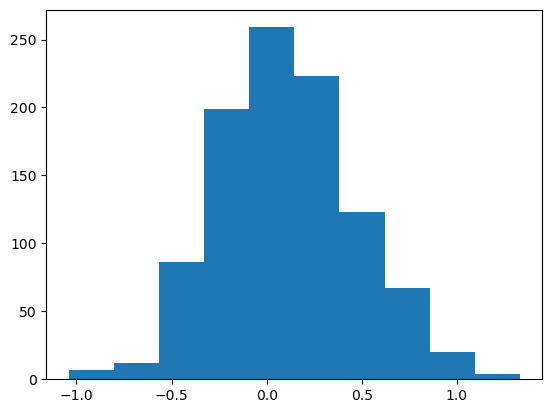

In [69]:
_ = plt.hist(bootstrapped1.mean(axis = 0) - bootstrapped2.mean(axis = 0))

In [75]:
np.quantile(np.median(bootstrapped1, axis = 0) - np.median(bootstrapped2,axis = 0), [0.025,0.975])

array([-1.,  1.])

In [78]:
clicked_df

,user_info_yandex_uid,exp_group,clicks,sum_pos,end2end_sum_pos,avg_position,avg_end2end_position
0,8978169951679310280,хронология,5.0,15.0,19.0,3.000000,3.800000
1,7035530161611247216,хронология,2.0,2.0,9.0,1.000000,4.500000
2,1513343321675365493,хронология,1.0,4.0,4.0,4.000000,4.000000
3,4413838491543262693,control,1.0,6.0,10.0,6.000000,10.000000
4,9893207711676019012,хронология,8.0,83.0,235.0,10.375000,29.375000
...,...,...,...,...,...,...,...
7153,8257872321636108341,control,3.0,64.0,86.0,21.333334,28.666666
7154,9794263021648977171,хронология,1.0,11.0,23.0,11.000000,23.000000
7155,1970327731620997336,control,1.0,30.0,30.0,30.000000,30.000000
7156,2826086081682530421,хронология,1.0,2.0,3.0,2.000000,3.000000


In [79]:
a = clicked_df[clicked_df.exp_group == 'хронология'].avg_end2end_position.to_numpy()
b = clicked_df[clicked_df.exp_group != 'хронология'].avg_end2end_position.to_numpy()

In [82]:
from scipy.stats import mannwhitneyu

In [83]:
mannwhitneyu(a,b)

MannwhitneyuResult(statistic=6490692.5, pvalue=0.32246175437378966)

In [86]:
k = clicked_df[clicked_df.exp_group == 'control'][['clicks', 'end2end_sum_pos']].sum().tolist()
k = k[1]/k[0]

In [88]:
clicked_df['linearized'] = clicked_df['avg_end2end_position'] - k*clicked_df['clicks']

In [90]:
a = clicked_df[clicked_df.exp_group == 'хронология'].linearized.to_numpy()
b = clicked_df[clicked_df.exp_group != 'хронология'].linearized.to_numpy()

In [93]:
ttest_ind(a,b,equal_var = False)

Ttest_indResult(statistic=-0.22826844434688687, pvalue=0.8194444556346026)

In [101]:
q = '''
    select *
    from df
    where user_info_yandex_uid in
    (
    SELECT user_info_yandex_uid
    FROM clicked_df
    GROUP BY user_info_yandex_uid
    HAVING count(distinct exp_group) > 1
    )
'''

fraud = duckdb.query(q).to_df()

In [105]:
fraud.sort_values(by = ['user_info_yandex_uid', 'd']).head(100)

,d,exp_group,bot_flg,user_info_yandex_uid,total_clicks_,time_to_first_click_,first_click_pos_,sum_pos,end2end_sum_pos,queries,empty_results,dt
8,01/05/23,хронология,0,3268047801667731986,0,0,0,0,0,1,0,2023-05-01
13,01/05/23,хронология,0,3268047801667731986,2,12,4,3,4,5,0,2023-05-01
17,01/05/23,хронология,0,3268047801667731986,0,0,0,0,0,1,0,2023-05-01
1,02/05/23,хронология,0,3268047801667731986,2,12,3,3,3,5,0,2023-05-02
10,27/04/23,control,0,3268047801667731986,3,18,3,3,3,4,0,2023-04-27
14,28/04/23,control,0,3268047801667731986,0,0,0,0,0,3,0,2023-04-28
9,29/04/23,control,0,3268047801667731986,1,8,1,1,1,4,2,2023-04-29
12,30/04/23,хронология,0,3268047801667731986,1,5,1,1,1,1,0,2023-04-30
3,26/04/23,control,0,3976503551669883618,1,296,6,6,6,1,0,2023-04-26
4,26/04/23,control,0,3976503551669883618,0,0,0,0,0,1,0,2023-04-26


# Показатели, которые касаются кликов, нужно считать ТОЛЬКО по тем, кто кликнул хоть раз. 

## А похоже ли у них количество запросов?

In [19]:

q = '''
select exp_group, 
    sum(queries_empty_results) as empty_results,
    sum(queries) as queries,
    sum(queries_empty_results)/sum(queries) as empty_results_ratio
from (
SELECT user_info_yandex_uid, exp_group, 
    sum(queries) as queries,
    sum(empty_results) as queries_empty_results
FROM df
where bot_flg = 0
GROUP BY user_info_yandex_uid, exp_group
)
group by exp_group
'''

duckdb.query(q).to_df()

,exp_group,empty_results,queries,empty_results_ratio
0,control,39357.0,179146.0,0.219692
1,хронология,13375.0,175346.0,0.076278


## По сколько запросов делают боты и не-боты

In [24]:

q = '''
select exp_group, 
    bot_flg,
    avg(queries) as avg_queries,
    quantile_disc(queries, [0.25, 0.5, 0.75, 0.99]) as quantiles_queries,
    max(queries) as max_queries
from (
SELECT user_info_yandex_uid, exp_group, 
    bot_flg,
    sum(queries) as queries
FROM df
GROUP BY user_info_yandex_uid, exp_group, bot_flg
)
group by exp_group, bot_flg
'''

duckdb.query(q).to_df()

,exp_group,bot_flg,avg_queries,quantiles_queries,max_queries
0,хронология,1,34.329277,"[1.0, 1.0, 1.0, 1999.0]",2541.0
1,control,0,1.580022,"[1.0, 1.0, 1.0, 7.0]",4428.0
2,control,1,41.174768,"[1.0, 1.0, 1.0, 2019.0]",2521.0
3,хронология,0,1.545539,"[1.0, 1.0, 1.0, 9.0]",1994.0


In [25]:
q = '''
select groups, sum(1)
from (
SELECT user_info_yandex_uid, count(distinct exp_group) as groups
FROM df
GROUP BY user_info_yandex_uid
)
group by groups
'''

duckdb.query(q).to_df()

,groups,sum(1)
0,1,237951.0
1,2,20.0


## Посмотрите, как ведут себя те, кто попал в обе группы